<a href="https://colab.research.google.com/github/janhavighuge/Time-Series-Forecasting-with-XGBoost/blob/main/Time_Series_Forecasting_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


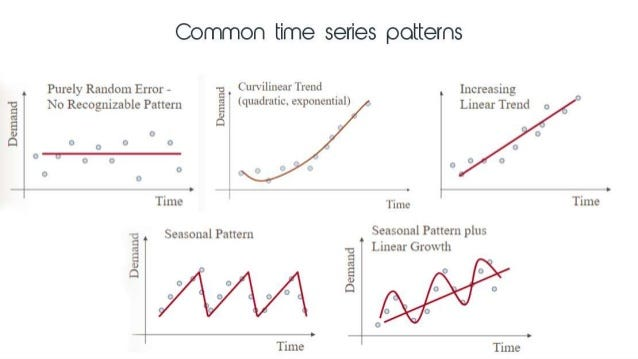

In [80]:
df = pd.read_csv('PJME_hourly.csv')      #read data from csv file
df = df.set_index('Datetime')            #set Datetime as index
df.index = pd.to_datetime(df.index)      #cast index from object to datetime

<Axes: title={'center': 'PJME Energy Use in Megawatts'}, xlabel='Datetime'>

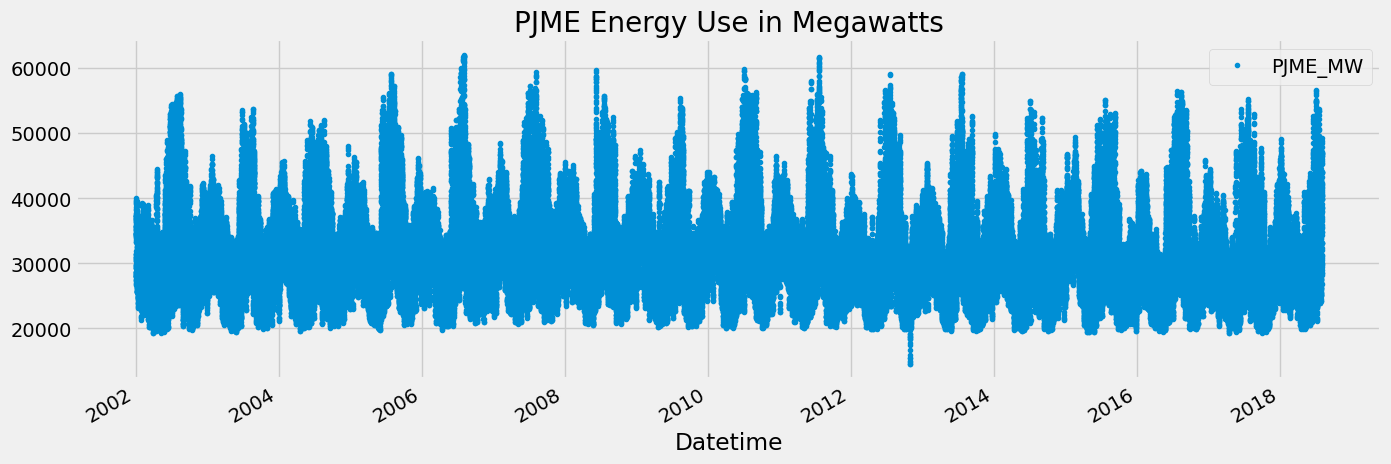

In [81]:
df.plot(style ='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in Megawatts')     #plot data

# TRAIN / TEST SPLIT

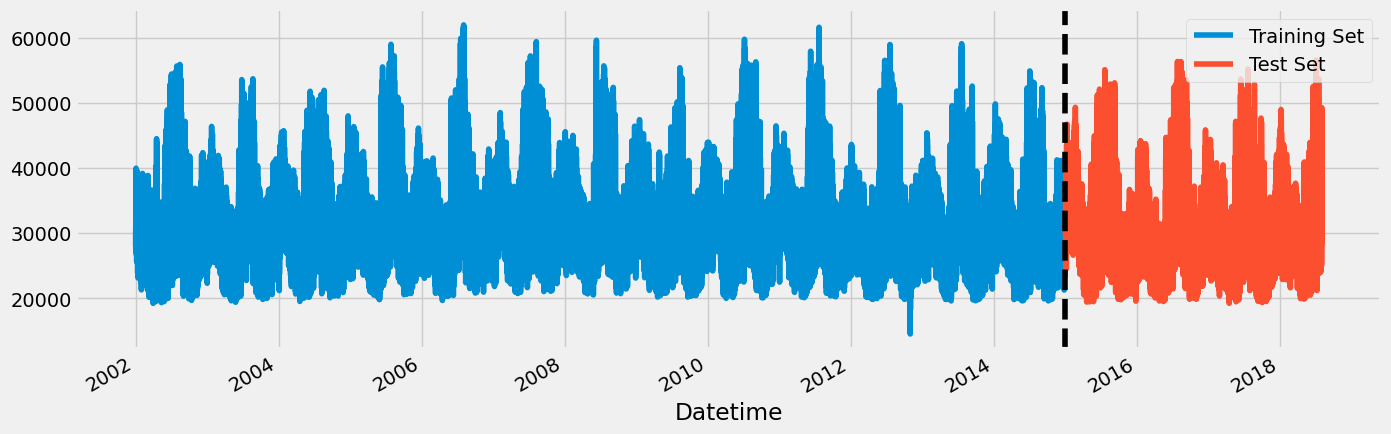

In [82]:
#split data into train and test sets
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))             #plotting training and testing data in same plot
train.plot(ax=ax, label = 'Training Set')
test.plot(ax=ax, label = 'Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set' ])

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

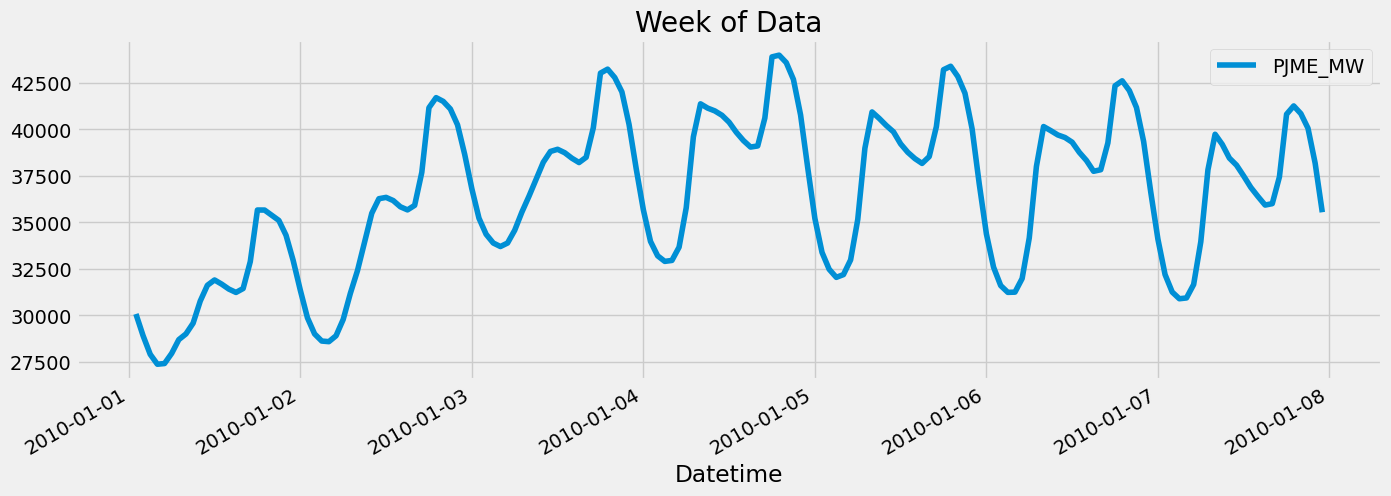

In [83]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(style ='-',
                                                                            figsize=(15, 5),
                                                                            color=color_pal[0],
                                                                            title='Week of Data')

#Feature Creation

In [84]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

  # Visualize our Feature/ Target Relationship

Text(0.5, 1.0, 'MW by HOUR')

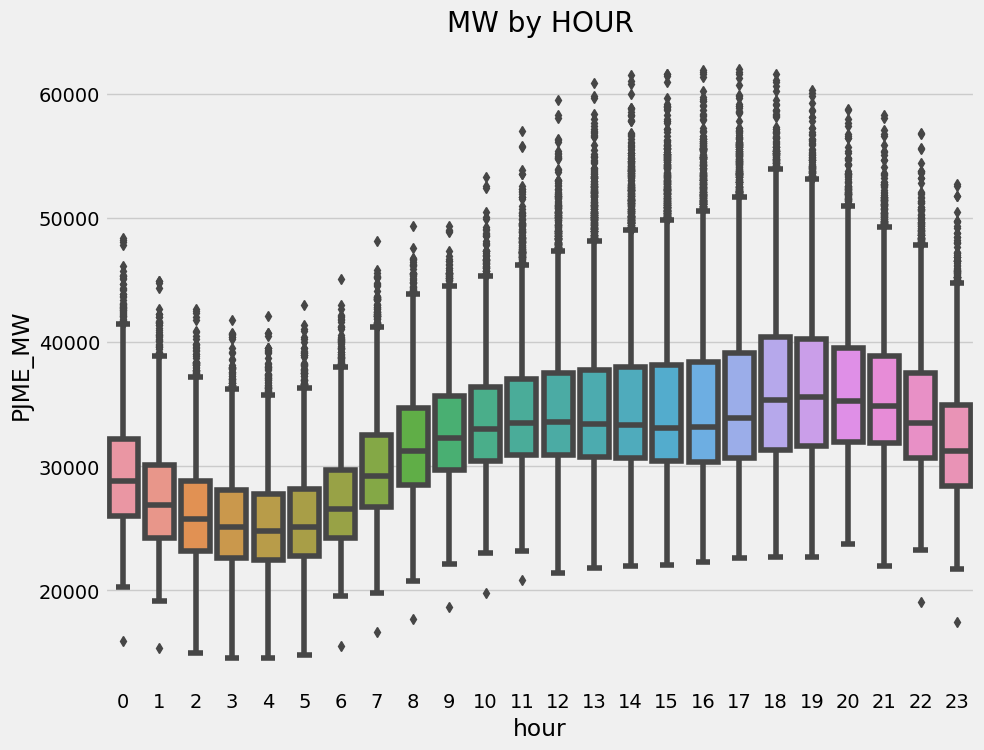

In [85]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data = df, x='hour', y='PJME_MW')
ax.set_title('MW by HOUR')

Text(0.5, 1.0, 'MW by HOUR')

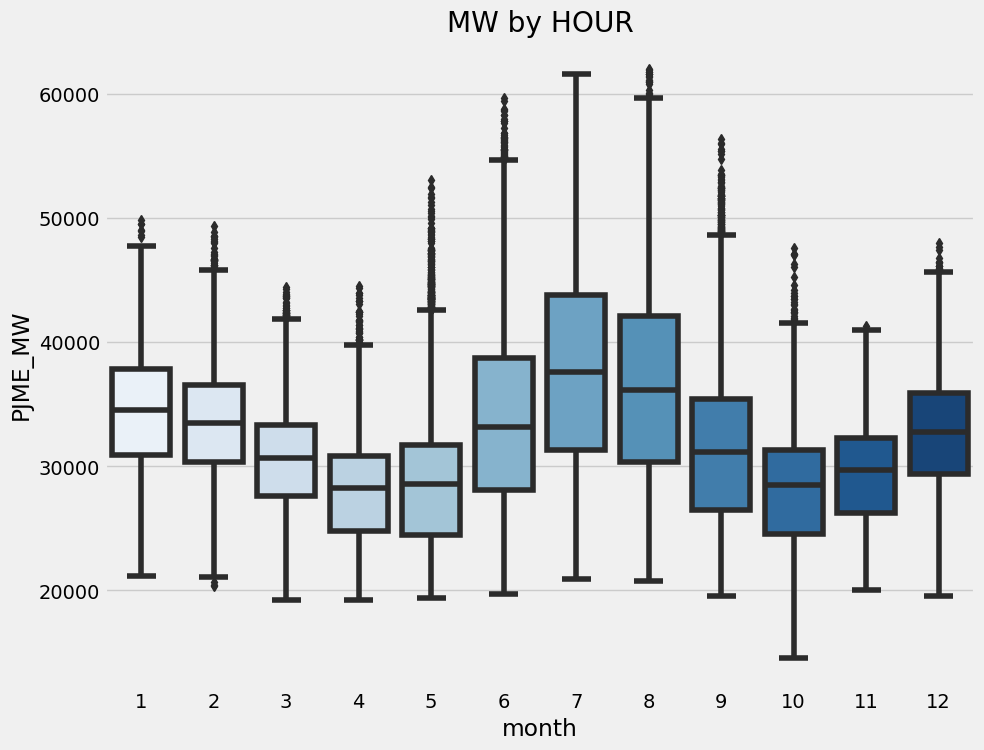

In [86]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data = df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by HOUR')

# Create model

In [87]:
train =create_features(train)
test =create_features(test)

FEATURES = ['hour','dayofweek','quarter','month','year','dayofyear']
TARGET = 'PJME_MW'

In [88]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [89]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],verbose =100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Feature Importance

In [90]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

<Axes: title={'center': 'Feature Importance'}>

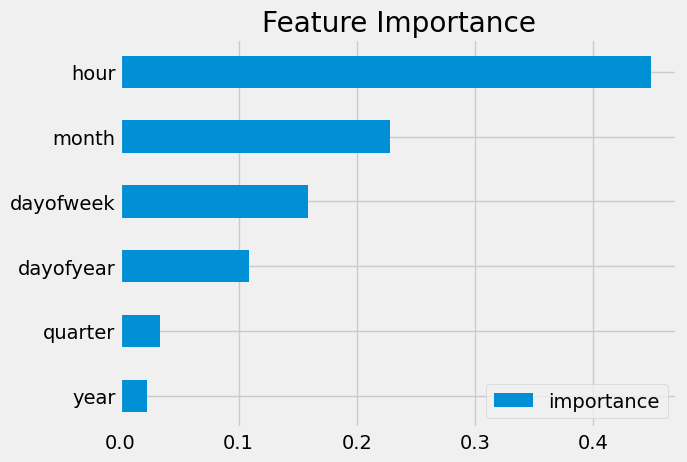

In [91]:
fi.sort_values('importance').plot(kind='barh', title = 'Feature Importance')   #plotting the importance of features used in the model

# Forecast on Test

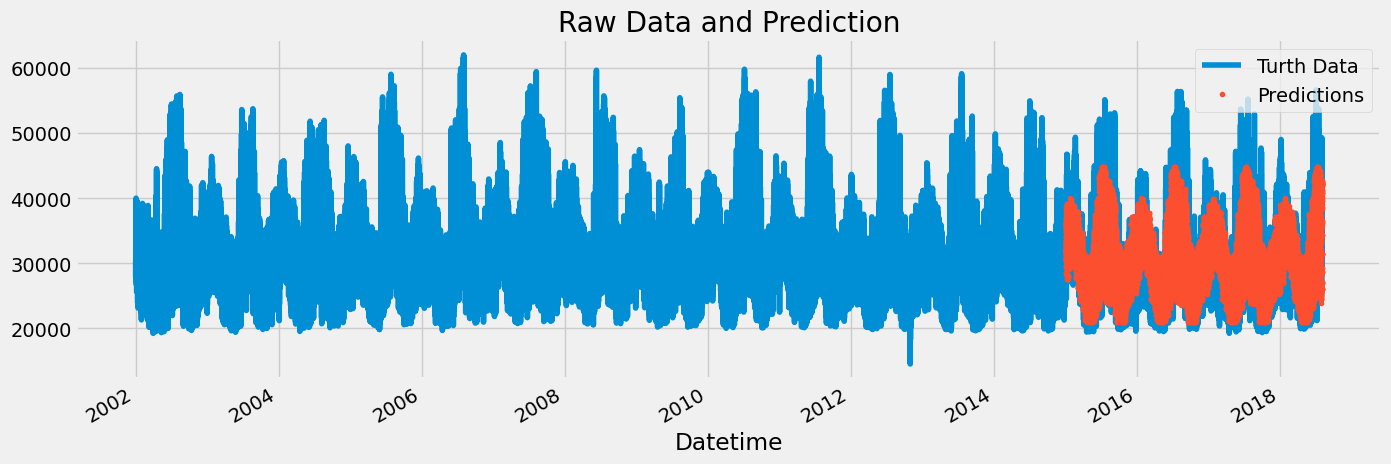

In [92]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']],how ='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Turth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()
#predictions plotted on top of training data set

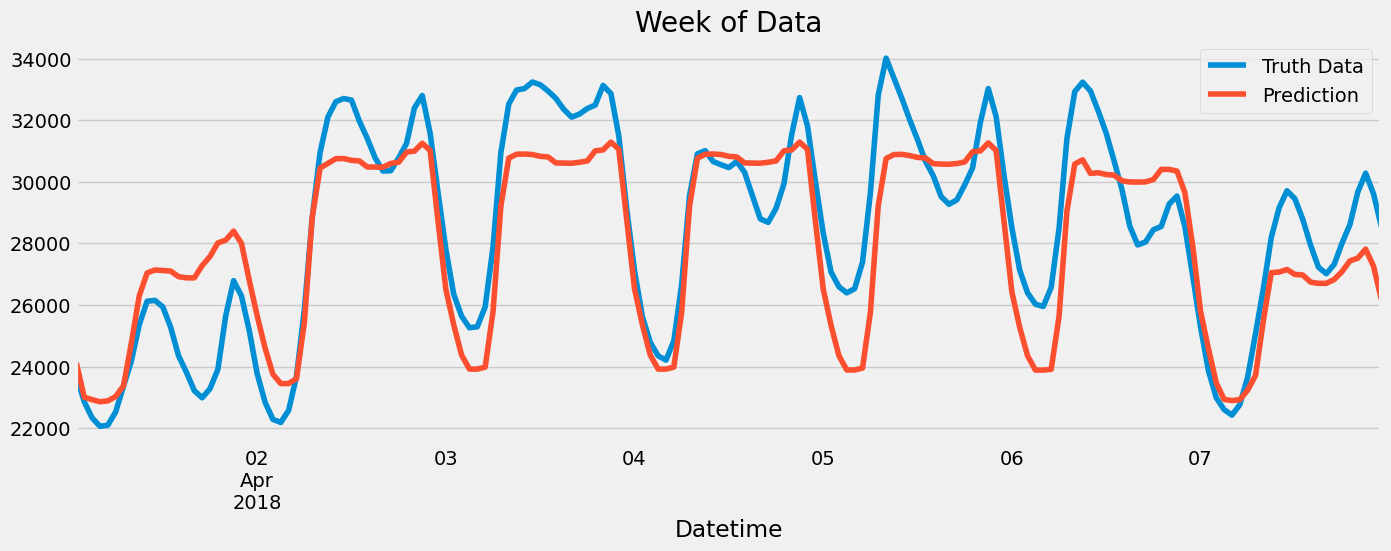

In [93]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
.plot(figsize=(15, 5), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction']\
.plot(style ='-')
plt.legend(['Truth Data','Prediction'])
plt.show()


In [94]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print (f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3715.93


# Calculate Error


*   Look at the best and worst predicted days



In [95]:
#worst predicted days
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False). head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

In [96]:
#best predicted days
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=True). head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64

# Next steps-
- More robust cross validation
- Add more features(weather forecast, holidays)